# Сравнение дистанций

In [1]:
import json
import numpy as np
import re
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
from matplotlib.dates import MO

%matplotlib inline

In [2]:
class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

In [13]:
def plot(cos_days, start_day, end_day, label):
    plt.rcParams['figure.figsize'] = (20.0, 8.0)
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()

    myFmt = mdates.DateFormatter('%d.%m.%Y')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))

    datemin = datetime.datetime.fromtimestamp(start_day/1000) - datetime.timedelta(days=7)
    datemax = datetime.datetime.fromtimestamp(end_day/1000) + datetime.timedelta(days=7)
    ax.set_xlim(datemin, datemax)

    x = list(map(lambda d: datetime.datetime.fromtimestamp(int(d)/1000), cos_days.keys()))
    y = list(cos_days.values())

    plt.plot(x, y, label = label)
    plt.legend(loc='upper right')
    plt.gcf().autofmt_xdate(rotation=60)

In [4]:
def load_sorted_news(path):
    news = []
    with open(path, encoding="utf8") as f:
        for line in f:
            news.append(News.from_json(line))
    return sorted(news, key=lambda w: w.date)

In [5]:
def coumpute_tfidf_matrix(news):
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda text: text.split(" "), ngram_range=(1, 3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(map(lambda n: n.content, news))
    return (tfidf_vectorizer, tfidf_matrix)

In [6]:
def compute_distance(start_day, end_day, step, news, year_mean_vector, vectorizer, distance):
    cos_days = {}

    for start in range(start_day, end_day, step):
        end = start + step
        day_news = list(filter(lambda w: w.date >= start and w.date <= end, news))
        tfidf_day = vectorizer.transform(map(lambda n: n.content, day_news))
        day_mean = np.array(tfidf_day.mean(axis=0))[0]
        cos_days[str(start)] = distance(year_mean_vector, day_mean)
        
    return cos_days

In [7]:
day_millis = 24*60*60*1000

# 2016 год

In [8]:
start_2016 = 1451595600*1000
end_2016 = 1483217999*1000
news_2016 = '/data/results/lenta.rbc.kp.vesti.2016.normalized.json'

news = load_sorted_news(news_2016)

print("count news: %s" % len(news))
print("start time: %s millis" % list(map(lambda w: w.date, news[:1]))[0])
print("end time: %s millis" % list(map(lambda w: w.date, news[-1:]))[0])

(vectorizer, tfidf_matrix) = coumpute_tfidf_matrix(news)
year_mean = np.array(tfidf_matrix.mean(axis=0))[0]

count news: 54166
start time: 1451599745000 millis
end time: 1483216945000 millis


## Косинус

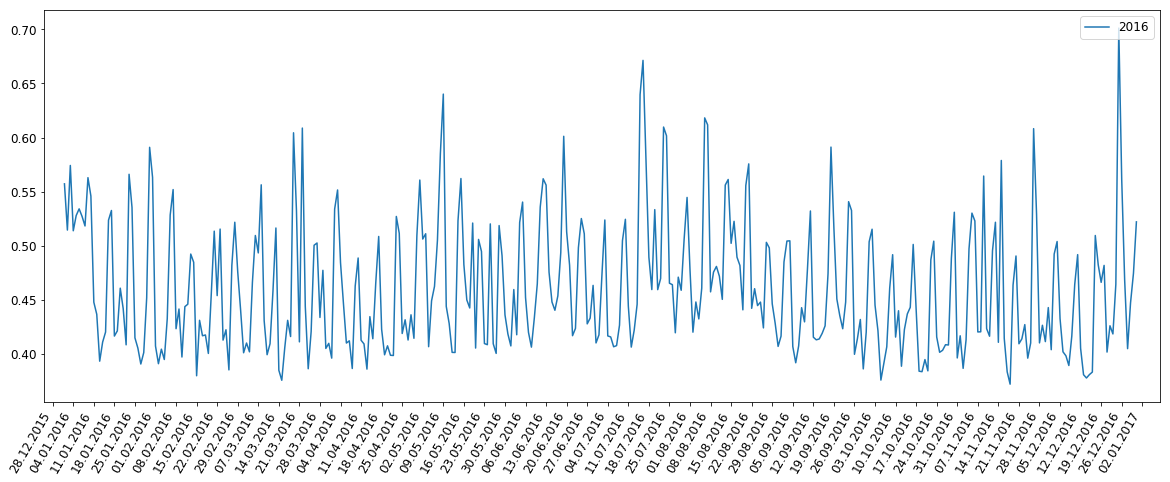

In [12]:
cos_days = compute_distance(start_2016, end_2016, day_millis, news, year_mean, vectorizer, spatial.distance.cosine)

plot(cos_days, start_2016, end_2016, "2016")

## Угол

In [14]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

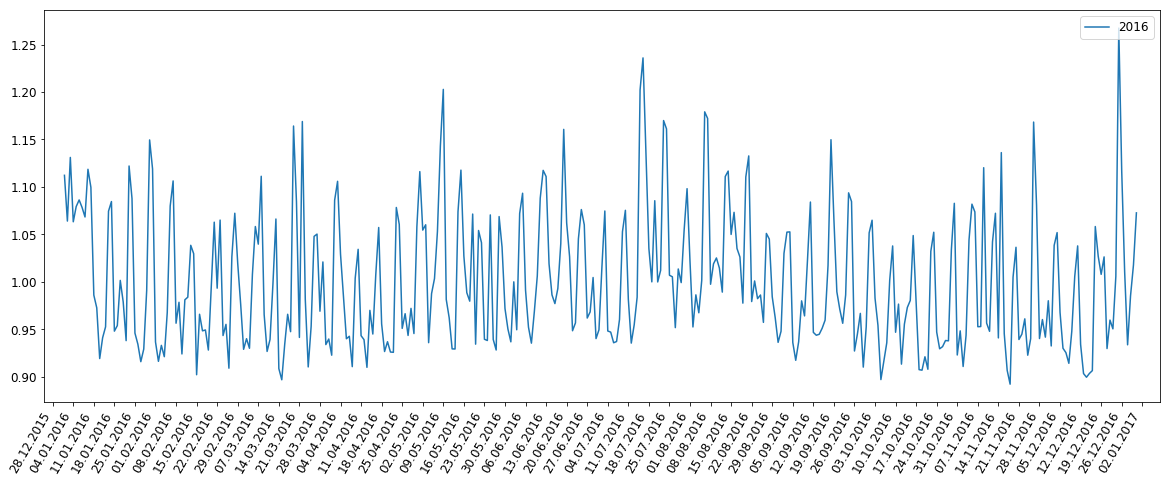

In [15]:
angle_days = compute_distance(start_2016, end_2016, day_millis, news, year_mean, vectorizer, angle)

plot(angle_days, start_2016, end_2016, "2016")

## Евклидово расстояние

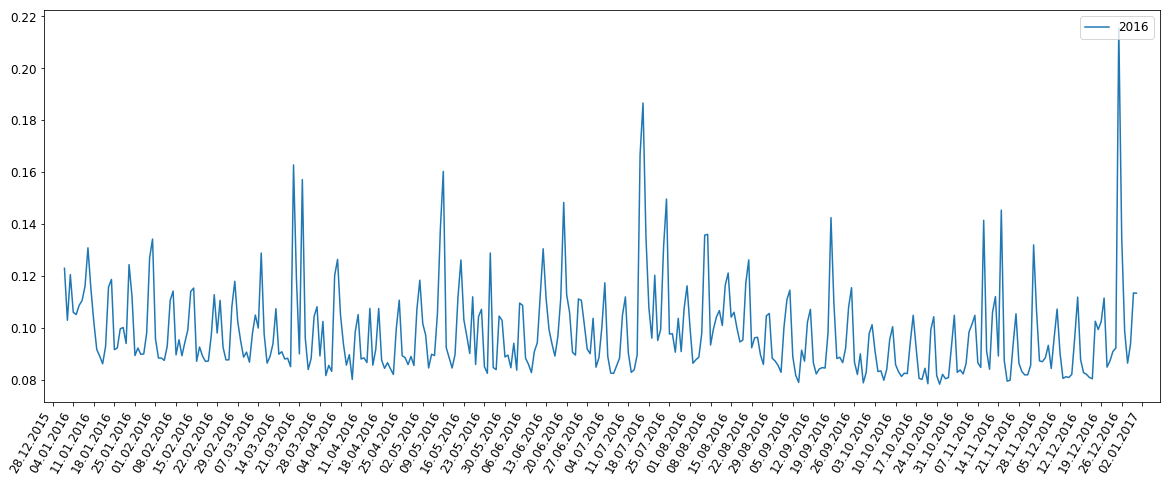

In [16]:
cos_euclidean = compute_distance(start_2016, end_2016, day_millis, news, year_mean, vectorizer, spatial.distance.euclidean)

plot(cos_euclidean, start_2016, end_2016, "2016")

## Расстояние Чебышёва

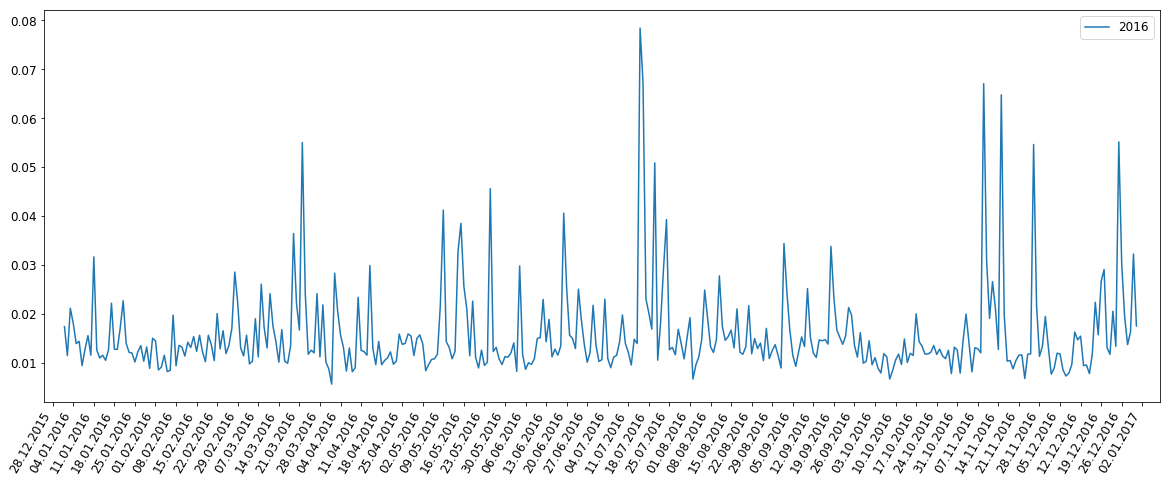

In [17]:
cos_chebyshev = compute_distance(start_2016, end_2016, day_millis, news, year_mean, vectorizer, spatial.distance.chebyshev)

plot(cos_chebyshev, start_2016, end_2016, "2016")